In [9]:
from utils import *
from datasets import *
from networks import *
from losses import *

# Importing required libraries
import numpy as np
import matplotlib.pyplot as plt

import sklearn.datasets
from sklearn.decomposition import PCA

import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm
# !pip install celluloid

## Test 1: Supervised training

Do representation split?

In [14]:
# Setting up data
dataset = DataSupervised(id='circles')
X, y = dataset.full()
dataloader = DataLoader(dataset, batch_size=200,
                        shuffle=True, num_workers=0)

# Setting up model training
model = NNClassifier(hidden=(10,))
lays_ = 5
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
pca = PCA(n_components=2)
epochs = 100

/mnt/c/Users/Surya Penmetsa/Desktop/github/fun/simclr_byol_analysis/networks.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = F.softmax(self.layers[-1](x))
/mnt/c/Users/Surya Penmetsa/Desktop/github/fun/simclr_byol_analysis/networks.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = F.softmax(y)


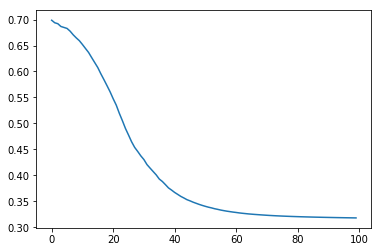

([<matplotlib.lines.Line2D at 0x7f2c01f9d320>], None)

In [15]:
losses = []
sup_data = [[] for i in range(5)]
for i in tqdm(range(epochs)):
    for i_batch, sample_batched in enumerate(dataloader):
        
#       import pdb; pdb.set_trace()
        X_batch, y_batch = sample_batched
        #Precit the output for Given input
        y_pred = model.forward(X_batch)
        #Compute Cross entropy loss
        loss = criterion(y_pred,y_batch)
        #Add loss to the list
        losses.append(loss.item())
        #Clear the previous gradients
        optimizer.zero_grad()
        #Compute gradients
        loss.backward()
        #Adjust weights
        optimizer.step()
        if(i_batch % 2 == 0):
            lays = model.forward_visible(X)
            for i, l in enumerate(lays):
                sup_data[i].append(pca.fit(l).transform(l))

plt.plot(losses), plt.show()

In [16]:
for i in range(lays_):
    separability(sup_data[i], y.numpy())

0.54
0.515
0.515
1.0
1.0


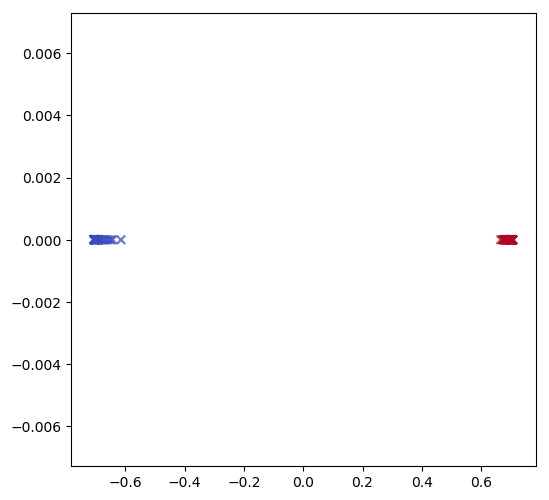

In [17]:
data = sup_data[4]
plt.figure(figsize=(6,6),dpi=100)
plt.scatter(data[-1][:,0], data[-1][:,1], c=y, marker='x', cmap=plt.cm.coolwarm, alpha=0.5)

Saved to supervised-representation-learning.mp4 in 16.525788068771362 seconds


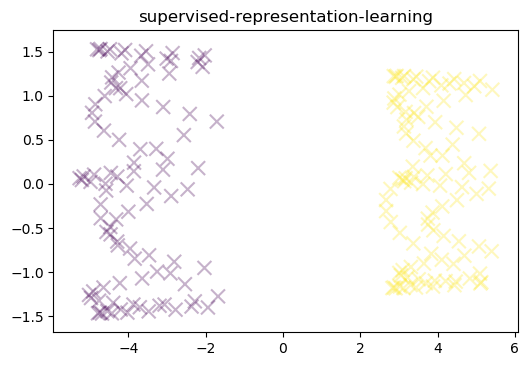

In [18]:
generate_video(sup_data[3], y,'supervised-representation-learning', res=100)

video progress: 87.50


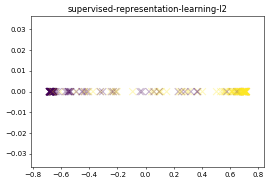

In [7]:
# To generate video rendering for all layers
# dicts = {0: 'input', 1: 'l1_pre', 2:'l1', 3:'l2_pre', 4:'l2'}
# for i in tqdm(range(4,5)):
#     generate_video(sup_data[i], y,'supervised-representation-learning-'+dicts[i], res=100)

/mnt/c/Users/Surya Penmetsa/Desktop/github/fun/simclr_byol_analysis/networks.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = F.softmax(self.layers[-1](x))
/mnt/c/Users/Surya Penmetsa/Desktop/github/fun/simclr_byol_analysis/networks.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(self.forward(x))


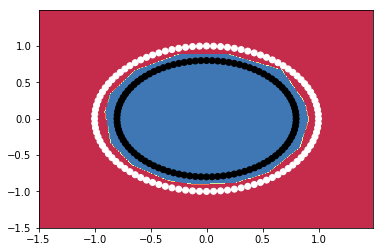

In [12]:
def predict(x):
    x = torch.from_numpy(x).type(torch.FloatTensor)
    ans = model.predict(x)
    return ans.numpy()

def plot_decision_boundary(pred_func,X,y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx,yy=np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.binary)
    
    
plot_decision_boundary(lambda x : predict(x) ,X.numpy(), y.numpy())

## Test 2: Training with only positive examples

Do representations collapse?

In [19]:
# Setting up data
dataset = DataUnsupervised()
X, y = dataset.full()
dataloader = DataLoader(dataset, batch_size=2,
                        shuffle=True, num_workers=0)

# Setting up model training
model = NN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
pca = PCA(n_components=2)
epochs = 4


40


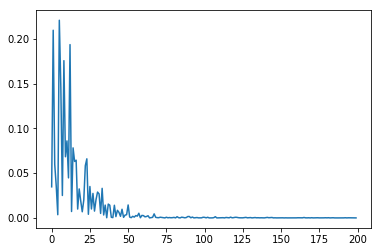

In [20]:
#List to store losses
losses = []
data = []
pca = PCA(n_components=2)
for i in tqdm(range(epochs)):
    for i_batch, sample_batched in enumerate(dataloader):
        Xpos, Xneg = sample_batched
        z_pos, z_neg = model.forward(Xpos), model.forward(Xneg)
#         import pdb;pdb.set_trace()
        loss = criterion(z_pos[0,:],z_pos[1,:]) + criterion(z_neg[0,:],z_neg[1,:])
        losses.append(loss.item())

        #Clear the previous gradients
        optimizer.zero_grad()
        #Compute gradients
        loss.backward()
        #Adjust weights
        optimizer.step()
        if(i_batch % 5 == 0):
            lays = model.forward_visible(X)
            out = pca.fit(lays[3]).transform(lays[3])
            data.append(out)
    
print(len(data))
plt.plot(losses)

Saved to representation-collapse.mp4 in 7.319822549819946 seconds


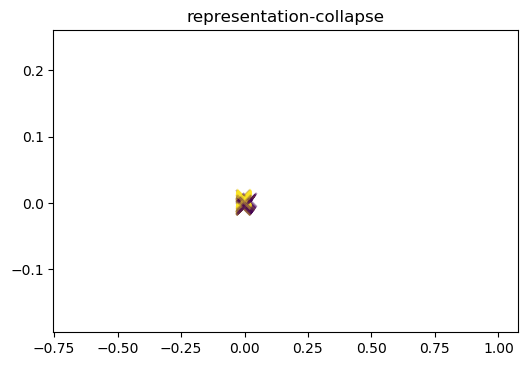

In [21]:
generate_video(data, y,'representation-collapse')

## Test 3: SimCLR style learning

https://arxiv.org/pdf/2002.05709.pdf

In [2]:
# Setting up data
dataset = DataUnsupervised(id='circles')
X, y = dataset.full()
bs = 20
dataloader = DataLoader(dataset, batch_size=bs,
                        shuffle=True, num_workers=0)

# Setting up model training
model = NN(hidden=(10,10,5))
lays_ = 6
criterion = nn.CosineSimilarity(dim=0, eps=1e-6)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
pca = PCA(n_components=2)
epochs = 400
xnt = NTXentLoss(device='cpu',batch_size=20, temperature=1, use_cosine_similarity=True)

/home/surya/anaconda3/lib/python3.6/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


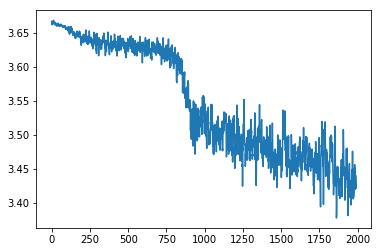

In [3]:
#List to store losses
losses = []
sup_data = [[] for i in range(lays_)]
style='simclr'
pca = PCA(n_components=2)
for i in tqdm(range(epochs)):
    for i_batch, sample_batched in enumerate(dataloader):
        Xpos, Xneg = sample_batched
        z_pos, z_neg = model.forward(Xpos), model.forward(Xneg)
        loss = xnt(z_pos,z_neg)
        
        losses.append(loss.item())

        #Clear the previous gradients
        optimizer.zero_grad()
        #Compute gradients
        loss.backward()
        #Adjust weights
        optimizer.step()
        if(i_batch % 5 == 0):
            lays = model.forward_visible(X)
            for i, l in enumerate(lays):
                sup_data[i].append(pca.fit(l).transform(l))
    
# print(len(data))
plt.plot(convolve(losses,10))

In [4]:
for i in range(lays_):
    separability(sup_data[i], y.numpy())

0.515
0.57
0.505
0.51
0.51
0.535


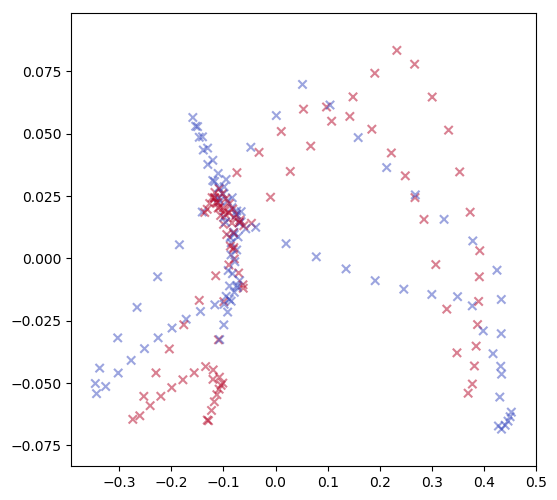

In [5]:
data = sup_data[-1]
plt.figure(figsize=(6,6),dpi=100)
plt.scatter(data[-1][:,0], data[-1][:,1], c=y, marker='x', cmap=plt.cm.coolwarm, alpha=0.5)

Saved to simclr.mp4 in 18.298112630844116 seconds


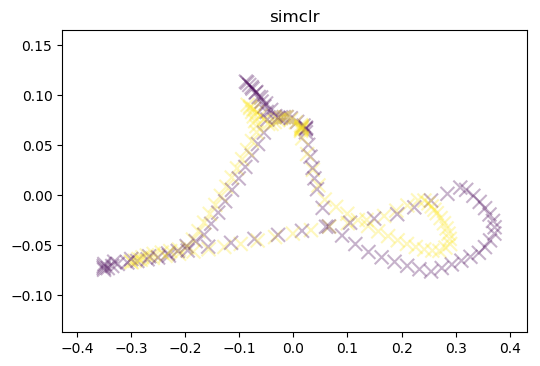

In [8]:
generate_video(sup_data[-1][:100], y,'simclr')

In [71]:
x = torch.LongTensor(10,7).random_(0, 2)

def cosine_pairwise(x):
    x = x.unsqueeze(0)
    x = x.permute((1, 2, 0))
    cos_sim_pairwise = F.cosine_similarity(x, x.unsqueeze(1), dim=-2)
    cos_sim_pairwise = cos_sim_pairwise.permute((2, 0, 1))
    return cos_sim_pairwise
print(x)
cos_sim_pairwise = cosine_pairwise(x.float())
print('cos sim pairwise\n', cos_sim_pairwise)

tensor([[0, 0, 0, 1, 1, 0, 0],
        [1, 0, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 1, 1, 0],
        [0, 1, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 1],
        [1, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 1, 0, 0],
        [1, 0, 1, 0, 0, 0, 0],
        [1, 0, 1, 1, 0, 1, 0],
        [0, 1, 0, 0, 0, 1, 1]])
cos sim pairwise
 tensor([[[1.0000, 0.4082, 0.4082, 0.0000, 0.0000, 0.5000, 0.5000, 0.0000,
          0.3536, 0.0000],
         [0.4082, 1.0000, 0.6667, 0.4082, 0.4082, 0.8165, 0.4082, 0.8165,
          0.5774, 0.0000],
         [0.4082, 0.6667, 1.0000, 0.4082, 0.4082, 0.4082, 0.4082, 0.4082,
          0.5774, 0.3333],
         [0.0000, 0.4082, 0.4082, 1.0000, 0.5000, 0.0000, 0.5000, 0.5000,
          0.3536, 0.4082],
         [0.0000, 0.4082, 0.4082, 0.5000, 1.0000, 0.0000, 0.0000, 0.5000,
          0.3536, 0.4082],
         [0.5000, 0.8165, 0.4082, 0.0000, 0.0000, 1.0000, 0.5000, 0.5000,
          0.3536, 0.0000],
         [0.5000, 0.4082, 0.4082, 0.5000, 0.0000, 0.5000, 1.0000,

In [4]:
mask = torch.ones((5, 5), dtype=torch.bool)
mask = mask.fill_diagonal_(0)

In [20]:
import torch
import torch.distributed as dist


class GatherLayer(torch.autograd.Function):
    '''Gather tensors from all process, supporting backward propagation.
    '''

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        output = [torch.zeros_like(input) \
            for _ in range(dist.get_world_size())]
        dist.all_gather(output, input)
        return tuple(output)

    @staticmethod
    def backward(ctx, *grads):
        input, = ctx.saved_tensors
        grad_out = torch.zeros_like(input)
        grad_out[:] = grads[dist.get_rank()]
        return grad_out
    
class NT_Xent(nn.Module):
    def __init__(self, batch_size, temperature, device, world_size):
        super(NT_Xent, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.device = device
        self.world_size = world_size

        self.mask = self.mask_correlated_samples(batch_size, world_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size, world_size):
        N = 2 * batch_size * world_size
        mask = torch.ones((N, N), dtype=torch.bool)
        mask = mask.fill_diagonal_(0)
        for i in range(batch_size * world_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):
        """
        We do not sample negative examples explicitly.
        Instead, given a positive pair, similar to (Chen et al., 2017), we treat the other 2(N − 1) augmented examples within a minibatch as negative examples.
        """
        N = 2 * self.batch_size * self.world_size

        z = torch.cat((z_i, z_j), dim=0)
        if self.world_size > 1:
            z = torch.cat(GatherLayer.apply(z), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, self.batch_size * self.world_size)
        sim_j_i = torch.diag(sim, -self.batch_size * self.world_size)

        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(
            N, 1
        )
        negative_samples = sim[self.mask].reshape(N, -1)

        labels = torch.zeros(N).to(positive_samples.device).long()
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        return loss

## Rough, ignore everything below

In [3]:
#List to store losses
losses = []
data = []
pca = PCA(n_components=2)
for i in tqdm(range(epochs)):
    for i_batch, sample_batched in enumerate(dataloader):
        Xpos, Xneg = sample_batched
        z_pos, z_neg = model.forward(Xpos), model.forward(Xneg)
        
        reg = reps[0].pow(2).mul(0.5).mean() + reps[1].pow(2).mul(0.5).mean()
        main = criterion(reps[0],reps[1])
        loss = main
        losses.append([main.item(), reg.item(), loss.item()])

        #Clear the previous gradients
        optimizer.zero_grad()
        #Compute gradients
        loss.backward()
        #Adjust weights
        optimizer.step()
        if(i_batch % 5 == 0):
            lays = model.forward_visible(X)
            out = pca.fit(lays[2]).transform(lays[2])
            data.append(out)
    
print(len(data))
plt.plot(losses)
plt.legend(['main','reg','total'])

AttributeError: 'list' object has no attribute 'dim'

In [37]:
# Create a pytorch class for a linear network 
class NeuralNetClassifier(nn.Module):
    def __init__(self, in_size=2):
        super(NeuralNetClassifier, self).__init__()
        self.fc1 = nn.Linear(in_size, 10)
        self.fc2 = nn.Linear(10, 3)

    def forward(self, x):
        y = self.fc2(F.relu(self.fc1(x)))
        return y

    def forward_visible(self, x):
        with torch.no_grad():
            l1_pre = self.fc1(x)
            layer1 = F.relu(l1_pre)
            layer2 = torch.sigmoid(self.fc2(layer1))
            return l1_pre, layer1, layer2

In [38]:
from torch.utils.data import Dataset, DataLoader
import sklearn.datasets

class BYOLData(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, id='moon'):
        if(id == 'moon'):
            size = 200
            X,y = sklearn.datasets.make_moons(size,noise=0.2) 
            self.X_pos = X[y==1,:]
            self.X_neg = X[y==0,:]
            self.length = size // 2
        else:
            raise

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        choice = np.random.randint(low = 0, high=2)
        if(choice == 0):
            return torch.from_numpy(self.X_neg[idx, :]).type(torch.FloatTensor)
        elif(choice == 1):
            return torch.from_numpy(self.X_pos[idx, :]).type(torch.FloatTensor)
        else:
            raise

dataset = BYOLData()

dataloader = DataLoader(dataset, batch_size=2,
                        shuffle=True, num_workers=0)

In [53]:
k = pca.fit(np.ones((10,2)))
pca.fit(np.ones((10,2))).transform(np.ones((10,2)))
print(pca.mean_, pca.components_, pca.whiten)


[1. 1.] [[1. 0.]
 [0. 1.]] False


/home/surya/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/pca.py:425: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


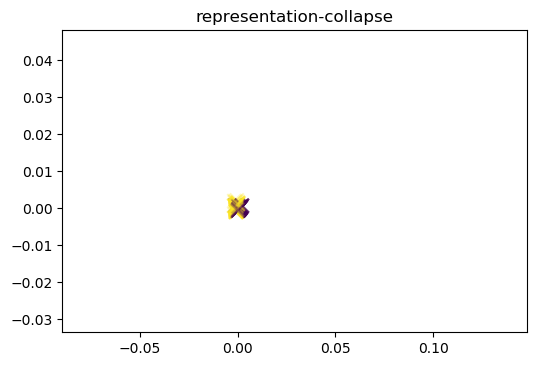

In [43]:
generate_video(data, y,'representation-collapse')

In [18]:
lays = model.forward_visible(X)

def to_2d(layers):    
    pca = PCA(n_components=2)
    out = []
    for l in layers:
        out.append(pca.fit(l).transform(l))
    return out
lays = to_2d(lays)

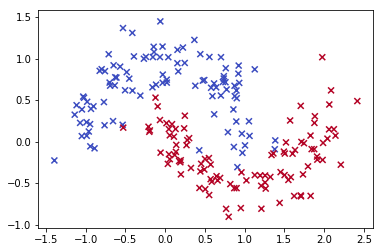

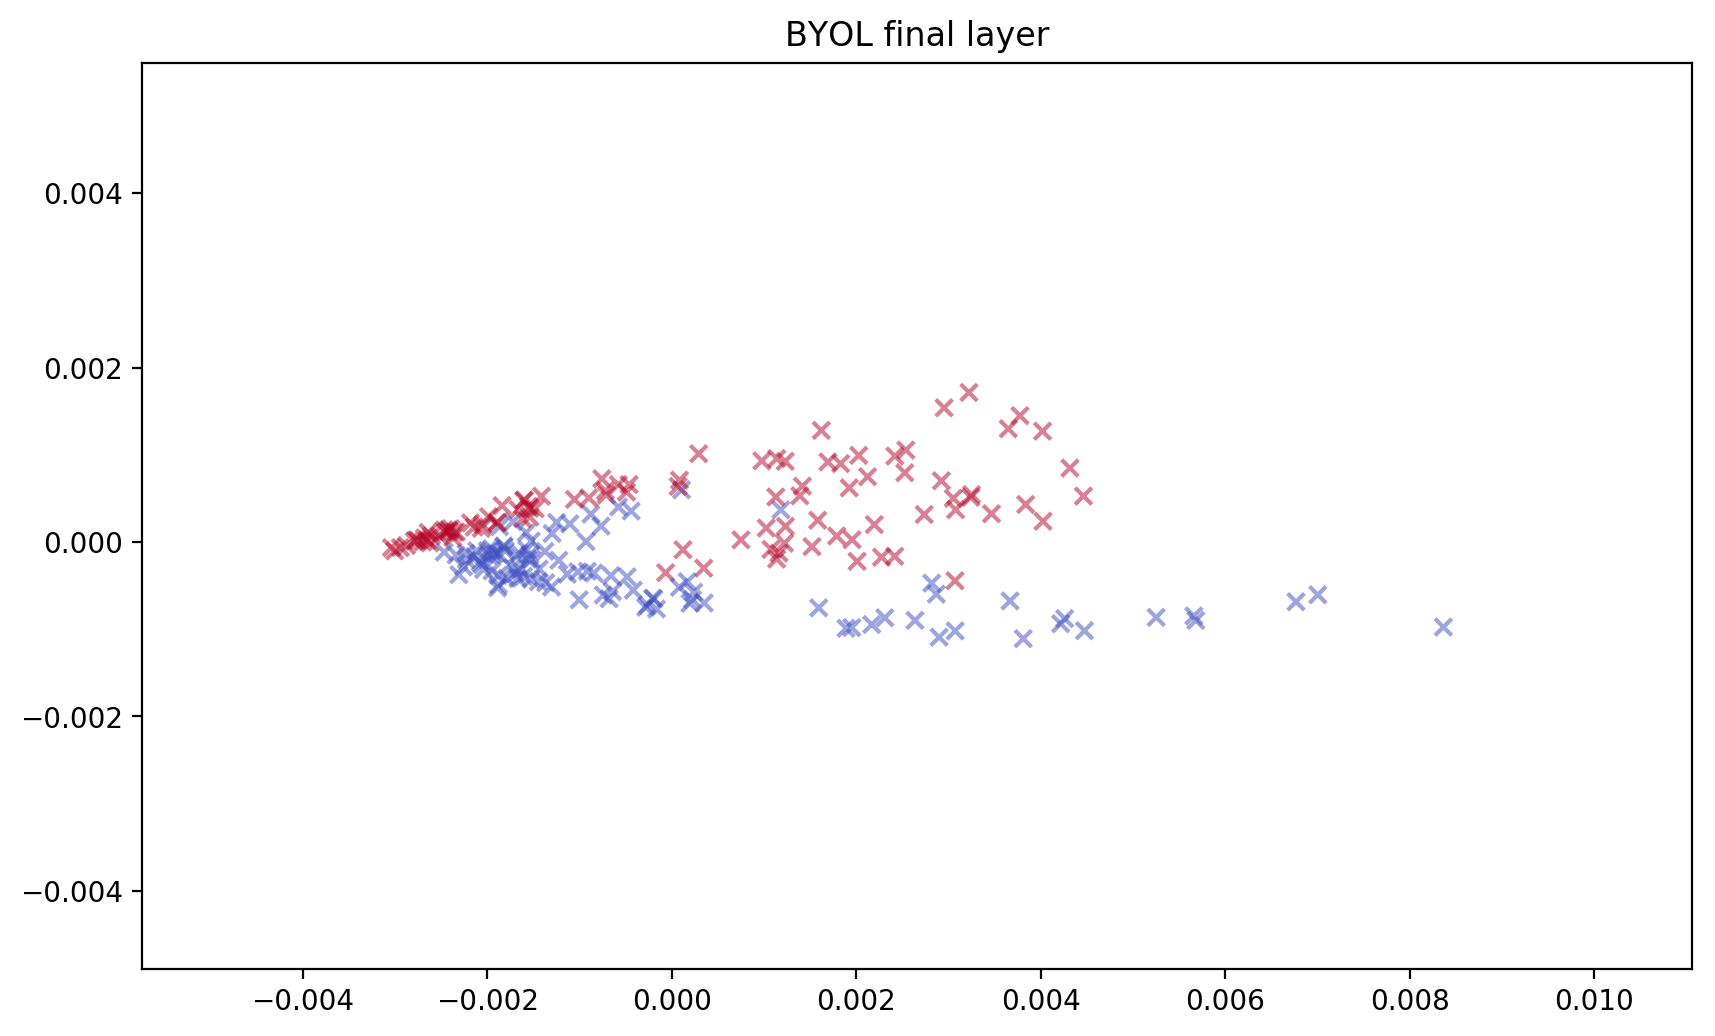

In [19]:
plt.scatter(X[:,0], X[:,1], c=y, marker='x', cmap=plt.cm.coolwarm); plt.show()
# plt.scatter(lays[0][:,0], lays[0][:,1], c=y, marker='x', cmap=plt.cm.coolwarm); plt.show()
# plt.scatter(lays[1][:,0], lays[1][:,1], c=y, marker='x', cmap=plt.cm.coolwarm); plt.show()
plt.figure(figsize=(10,6),dpi=200)
plt.scatter(lays[2][:,0], lays[2][:,1], c=y, marker='x', cmap=plt.cm.coolwarm, alpha=0.5)
plt.title('BYOL final layer')
plt.show()

## SimCLR style learning

In [12]:
# Create a pytorch class for a linear network 
class NeuralNetClassifier(nn.Module):
    def __init__(self, in_size=2):
        super(NeuralNetClassifier, self).__init__()
        self.fc1 = nn.Linear(in_size, 5)
        self.fc2 = nn.Linear(5, 3)

    def forward(self, x):
        y = torch.sigmoid(self.fc2(F.sigmoid(self.fc1(x))))
        return y

    def forward_visible(self, x):
        with torch.no_grad():
            l1_pre = self.fc1(x)
            l1 = F.relu(l1_pre)
            l2_pre = self.fc2(l1)
            l2 = torch.sigmoid(l2_pre)
            return x, l1_pre, l1, l2_pre, l2

    def predict(self,x):
        #Apply softmax to output
        pred = F.softmax(self.forward(x))
        ans = []
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

In [13]:
from torch.utils.data import Dataset, DataLoader
import sklearn.datasets

class SimCLRData(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, id='moon'):
        if(id == 'moon'):
            size = 200
            X,y = sklearn.datasets.make_moons(size,noise=0.2) 
            self.X_pos = X[y==1,:]
            self.X_neg = X[y==0,:]
            self.length = size // 2
        else:
            raise

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return torch.from_numpy(self.X_pos[idx, :]).type(torch.FloatTensor), \
                torch.from_numpy(self.X_neg[idx, :]).type(torch.FloatTensor)

dataset = SimCLRData()

dataloader = DataLoader(dataset, batch_size=20,
                        shuffle=True, num_workers=0)

In [14]:
# https://github.com/sthalles/SimCLR/blob/e8a690ae4f4359528cfba6f270a9226e3733b7fa/loss/nt_xent.py
class NTXentLoss(torch.nn.Module):

    def __init__(self):
        super(NTXentLoss, self).__init__()
        self.batch_size = 20
        self.temperature = 0.5
        self.device = 'cpu'
        self.softmax = torch.nn.Softmax(dim=-1)
        self.mask_samples_from_same_repr = self._get_correlated_mask().type(torch.bool)
        self.similarity_function = self._get_similarity_function(True)
        self.criterion = torch.nn.CrossEntropyLoss(reduction="sum")

    def _get_similarity_function(self, use_cosine_similarity):
        if use_cosine_similarity:
            self._cosine_similarity = torch.nn.CosineSimilarity(dim=-1)
            return self._cosine_simililarity
        else:
            return self._dot_simililarity

    def _get_correlated_mask(self):
        diag = np.eye(2 * self.batch_size)
        l1 = np.eye((2 * self.batch_size), 2 * self.batch_size, k=-self.batch_size)
        l2 = np.eye((2 * self.batch_size), 2 * self.batch_size, k=self.batch_size)
        mask = torch.from_numpy((diag + l1 + l2))
        mask = (1 - mask).type(torch.bool)
        return mask.to(self.device)

    @staticmethod
    def _dot_simililarity(x, y):
        v = torch.tensordot(x.unsqueeze(1), y.T.unsqueeze(0), dims=2)
        # x shape: (N, 1, C)
        # y shape: (1, C, 2N)
        # v shape: (N, 2N)
        return v

    def _cosine_simililarity(self, x, y):
        # x shape: (N, 1, C)
        # y shape: (1, 2N, C)
        # v shape: (N, 2N)
        v = self._cosine_similarity(x.unsqueeze(1), y.unsqueeze(0))
        return v

    def forward(self, zis, zjs):
        representations = torch.cat([zjs, zis], dim=0)

        similarity_matrix = self.similarity_function(representations, representations)

        # filter out the scores from the positive samples
        l_pos = torch.diag(similarity_matrix, self.batch_size)
        r_pos = torch.diag(similarity_matrix, -self.batch_size)
        positives = torch.cat([l_pos, r_pos]).view(2 * self.batch_size, 1)

        negatives = similarity_matrix[self.mask_samples_from_same_repr].view(2 * self.batch_size, -1)

        logits = torch.cat((positives, negatives), dim=1)
        logits /= self.temperature

        labels = torch.zeros(2 * self.batch_size).to(self.device).long()
        loss = self.criterion(logits, labels)

        return loss / (2 * self.batch_size)

In [19]:
model = NeuralNetClassifier()
# criterion = nn.CrossEntropyLoss()
similarity = torch.nn.CosineSimilarity(dim=-1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
pca = PCA(n_components=2)
nt_xent_criterion = NTXentLoss()

epochs = 20
losses = []
sup_data = [[] for i in range(5)]

for i in tqdm(range(epochs)):
    for i_batch, sample_batched in enumerate(dataloader):

        X_pos_batch, X_neg_batch = sample_batched
        
        z1 = model.forward(X_pos_batch)
        z2 = model.forward(X_neg_batch)
        import pdb;pdb.set_trace()
        loss = nt_xent_criterion(z1, z2)
#         z = torch.cat((z1,z2),0)
        
#         z = F.normalize(z, dim=1)
#         s = similarity(z, z)
#         import pdb; pdb.set_trace()
        
        #Add loss to the list
        losses.append(loss.item())
        #Clear the previous gradients
        optimizer.zero_grad()
        #Compute gradients
        loss.backward()
        #Adjust weights
        optimizer.step()
        if(i_batch % 20 == 0):
            lays = model.forward_visible(X)
            sup_data[0].append(pca.fit(lays[0]).transform(lays[0]))
            sup_data[1].append(pca.fit(lays[1]).transform(lays[1]))
            sup_data[2].append(pca.fit(lays[2]).transform(lays[2]))
            sup_data[3].append(pca.fit(lays[3]).transform(lays[3]))
            sup_data[4].append(pca.fit(lays[4]).transform(lays[4]))

plt.plot(losses)

/home/surya/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


> <ipython-input-19-38189d946c40>(20)<module>()
-> loss = nt_xent_criterion(z1, z2)
(Pdb) s
--Call--
> /home/surya/anaconda3/lib/python3.6/site-packages/torch/nn/modules/module.py(487)__call__()
-> def __call__(self, *input, **kwargs):
(Pdb) n
> /home/surya/anaconda3/lib/python3.6/site-packages/torch/nn/modules/module.py(488)__call__()
-> for hook in self._forward_pre_hooks.values():
(Pdb) n
> /home/surya/anaconda3/lib/python3.6/site-packages/torch/nn/modules/module.py(490)__call__()
-> if torch._C._get_tracing_state():
(Pdb) n
> /home/surya/anaconda3/lib/python3.6/site-packages/torch/nn/modules/module.py(493)__call__()
-> result = self.forward(*input, **kwargs)
(Pdb) s
--Call--
> <ipython-input-14-6221aa8c693e>(44)forward()
-> def forward(self, zis, zjs):
(Pdb) n
> <ipython-input-14-6221aa8c693e>(45)forward()
-> representations = torch.cat([zjs, zis], dim=0)
(Pdb) n
> <ipython-input-14-6221aa8c693e>(47)forward()
-> similarity_matrix = self.similarity_function(representations, represen

BdbQuit: 

In [ ]:
dicts = {0: 'input', 1: 'l1_pre', 2:'l1', 3:'l2_pre', 4:'l2'}
for i in tqdm(range(5)):
    generate_video(sup_data[i], y,'simclr-'+dicts[i])

In [ ]:
a = torch.randn(1)